In [3]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.pylabtools import figsize

from scipy.io import arff
import pandas as pd

import math

from sklearn import preprocessing
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import precision_score, recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import progressbar

from scipy.stats.stats import pearsonr, kendalltau, spearmanr

# 15 s

In [4]:
data = arff.loadarff('Data_VPN/TimeBasedFeatures-Dataset-15s-VPN.arff')
df = pd.DataFrame(data[0])

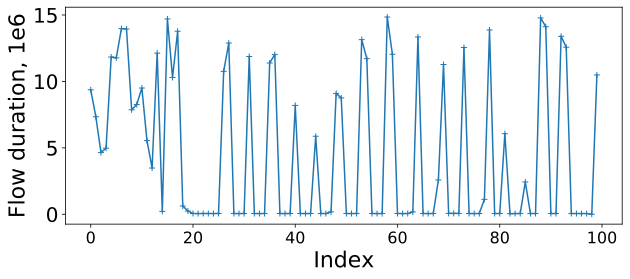

In [5]:
f, ax = plt.subplots(figsize=(10, 4))

x = np.arange(0, 100, 1).tolist()
y = df["duration"][0:100]/1000000
ax.plot(x, y, '+', linestyle='solid')

plt.xlabel('Index', size = 22);
plt.ylabel('Flow duration, 1e6', size = 22);
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=20)

plt.show()

In [6]:
df.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,...,267600.198443,1871488.0,1.983656e+06,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,b'Non-VPN'
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,...,221462.862028,1491627.0,3.572433e+06,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,b'Non-VPN'
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,...,217475.425246,1758922.0,1.758922e+06,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,b'Non-VPN'
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,...,436959.716436,1710925.0,2.382905e+06,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,b'Non-VPN'
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,...,436129.639296,1747431.0,2.400446e+06,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,b'Non-VPN'


In [8]:
X = df.drop('class1', axis=1)

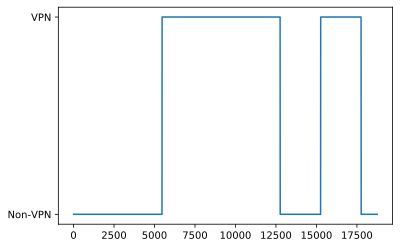

In [9]:
import matplotlib.pyplot as plt

y = df["class1"]
plt.plot(y)

In [11]:
lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
  if y[i] == b'Non-VPN':
    y_bin[i] = 0
  if y[i] == b'VPN':
    y_bin[i] = 1    

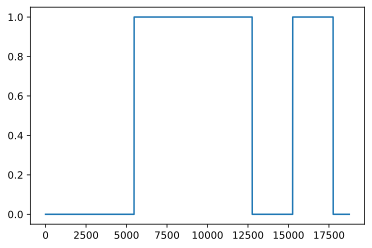

In [12]:
plt.plot(y_bin)

In [13]:
scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3,random_state = 42, shuffle=True, stratify=y_bin)

## Random Forest

In [14]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train, y_train.ravel())
    RF_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))

100% |########################################################################|


0.8978322672352523


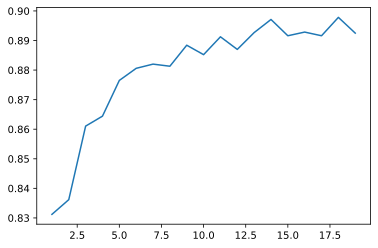

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

## Hurst test

In [16]:
def FirstDerivative(y):
  L = len(y)
  der = np.zeros(L)
  der[0] = 0
  for i in range(1, L):
    der[i] = y[i] - y[i-1]
  return der

In [17]:
def CalculateHurst(y, a, N_steps):
  hurst = np.zeros(N_steps)
  #progress = progressbar.ProgressBar()
  #for i in progress(range(0, N_steps)):
  for i in range(0, N_steps):
    mx = max(y[0:a*(i+1)])
    mn = min(y[0:a*(i+1)])
    devi = np.std(y[0:a*(i+1)])
    hurst[i] = (mx-mn) / (devi + 1e-18)
    if(math.isnan(hurst[i])):
      print("Error!")
  return hurst

In [18]:
import progressbar

def GenerateNewFeatures(X, start_offset, w_size, a):
  N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
  L = N_steps * w_size
  N_features = X.shape[1]
  X_new = np.zeros((L, N_features))
  N_steps_window = int(np.floor(w_size / a))
  progress = progressbar.ProgressBar()
  for i in progress(range(0, N_features)):
    for j in range(0, N_steps):
      hurst = CalculateHurst(X[start_offset+j*w_size:start_offset+(j+1)*w_size, i], a, N_steps_window)
      #print(len(X.iloc[i*w_size:(i+1)*w_size, j]))
      #i_hurst = integral(hurst - np.mean(hurst))
      X_new[j*w_size:(j+1)*w_size, i] = FirstDerivative(hurst)
  return X_new

In [19]:
plt.savefig("Hurst/plot.png")

<Figure size 432x288 with 0 Axes>

In [21]:
def GeneratePlots(X, start_offset, w_size, a, feature_number, y):
  # Generate plots of rescaled ranges, derivative and label for a chosen feature
  # y = 1 -- VPN, y = 0 -- non-VPN
  N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
  L = N_steps * w_size
  N_features = X.shape[1]
  X_new = np.zeros((L, N_features))
  N_steps_window = int(np.floor(w_size / a))
  progress = progressbar.ProgressBar()
  for j in range(0, N_steps):
    if (j == 35):
      hurst = CalculateHurst(X[start_offset+j*w_size:start_offset+(j+1)*w_size, i], a, N_steps_window)
      #print(len(X.iloc[i*w_size:(i+1)*w_size, j]))
      #i_hurst = integral(hurst - np.mean(hurst))
      X_new[j*w_size:(j+1)*w_size, i] = FirstDerivative(hurst / max(hurst))
      plt.figure(j, figsize=(30, 10))
      print(j)
      plt.plot(hurst / max(hurst), "b--", linewidth=5.0, markersize=25, label='rescaled ranges')
      plt.plot(X_new[j*w_size:(j+1)*w_size, i], "r--", linewidth=5.0, markersize=25, label="derivative")
      plt.plot(y[j*w_size:(j+1)*w_size], "g--", linewidth=5.0, markersize=25, label="label, 1 - VPN, 0 - nonVPN")

      plt.legend(fontsize=25, ncol=1, loc='upper right', bbox_to_anchor=(1, 0.86))
      plt.grid(b=True, which='major', color='k', linestyle='-')
      plt.grid(b=True, which='minor', linestyle='--')
      plt.xlabel('Time index', fontsize = 50)
      plt.ylabel('Amplitude', fontsize = 50)
      plt.xticks(fontsize=45, rotation=0)
      plt.yticks(fontsize=45, rotation=0)

      sub_axes = plt.axes([.315, .62, .2, .2]) 
      sub_axes.plot(np.linspace(160, 249, 90), X_new[j*w_size+160:j*w_size + 250, i], c = 'r') 
      plt.xticks(fontsize=35, rotation=0)
      plt.yticks(fontsize=35, rotation=0)
      plt.grid(b=True, which='major', color='k', linestyle='-')
      plt.grid(b=True, which='minor', linestyle='--')

      sub_axes2 = plt.axes([.585, .32, .3, .2]) 
      sub_axes2.plot(np.linspace(280, 499, 220), X_new[j*w_size+280:j*w_size + 500, i], c = 'r')
      plt.xticks(fontsize=35, rotation=0)
      plt.yticks(fontsize=35, rotation=0)
      plt.grid(b=True, which='major', color='k', linestyle='-')
      plt.grid(b=True, which='minor', linestyle='--')

      #plt.savefig("/content/gdrive/My Drive/Nigmatullin/Hurst/plot.png")
      plt.savefig("Hurst/plot.png")
      plt.show() 
      plt.figure(1)
      plt.plot(X_new[j*w_size+150:j*w_size + 250, i])

      plt.figure(2)
      plt.plot(X_new[j*w_size+280:j*w_size + 500, i])

In [20]:
w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

100% |########################################################################|


35


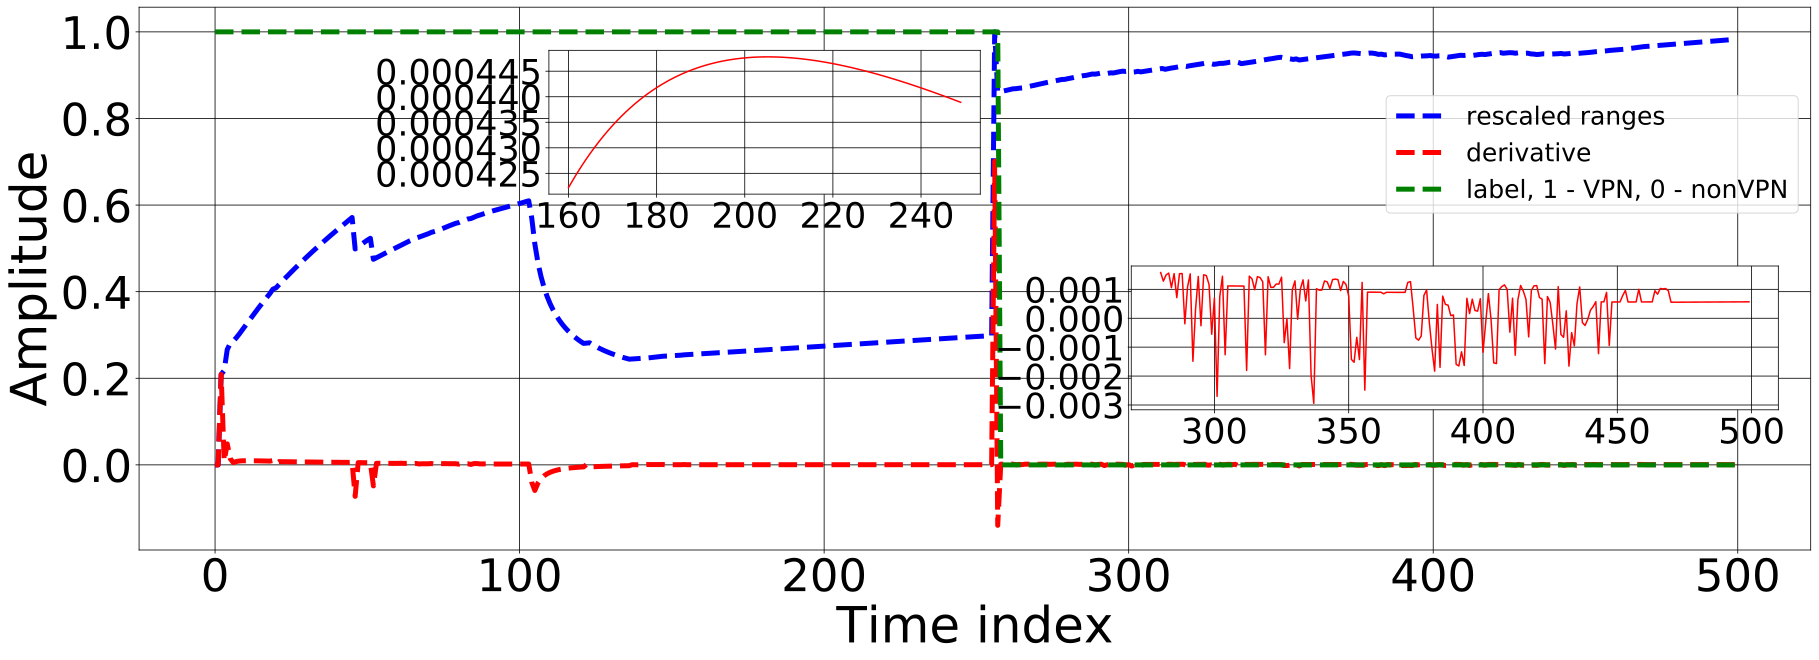

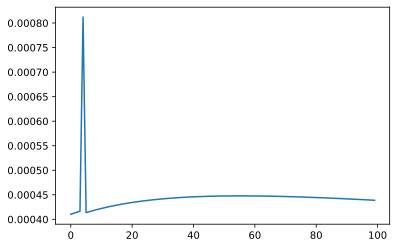

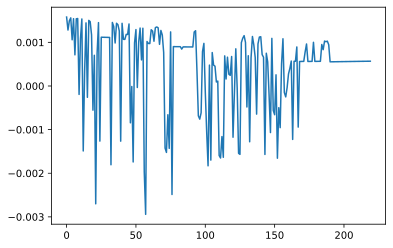

In [21]:
GeneratePlots(X, start_offset, w_size, a, 0, y_bin)

35


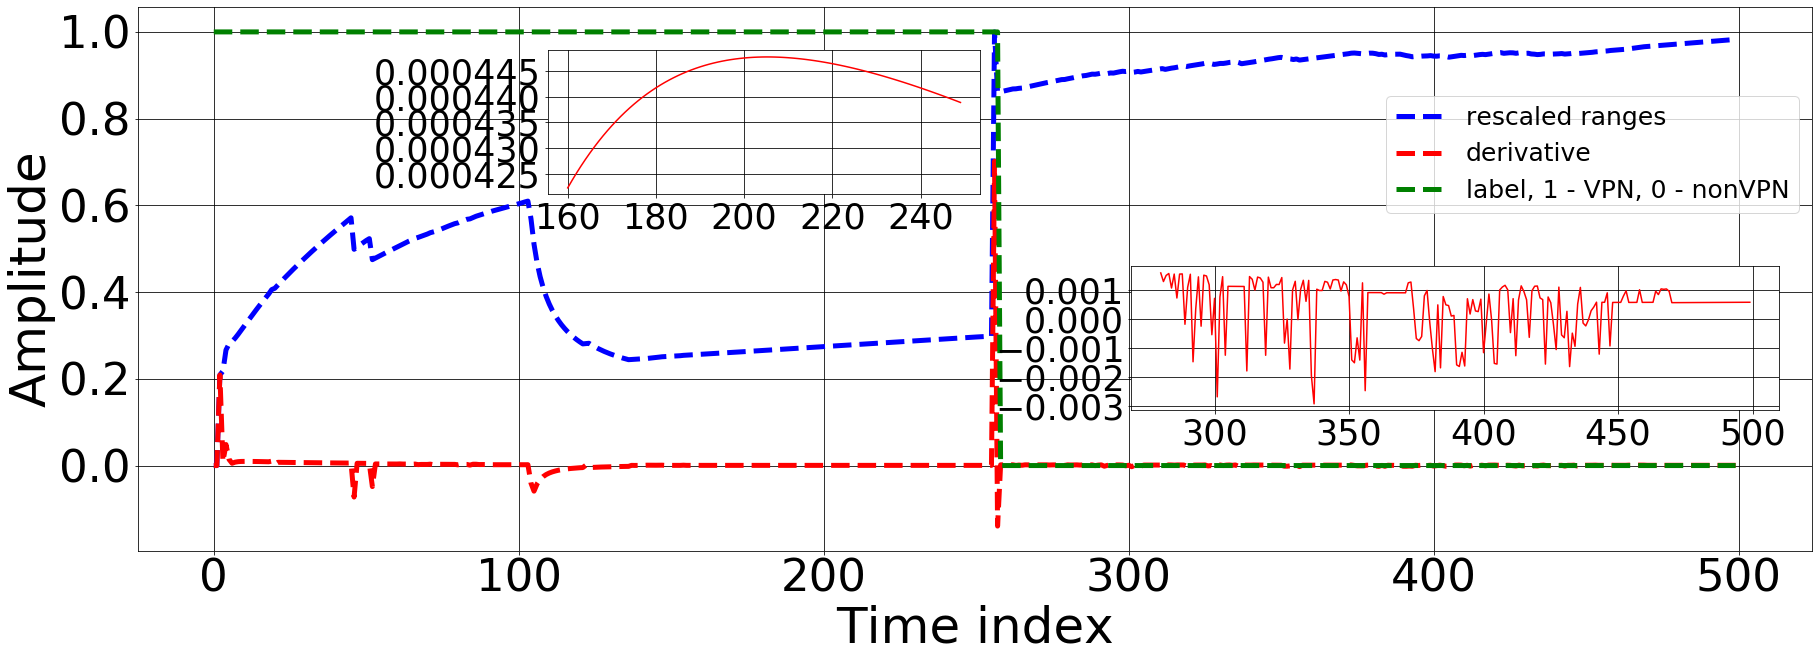

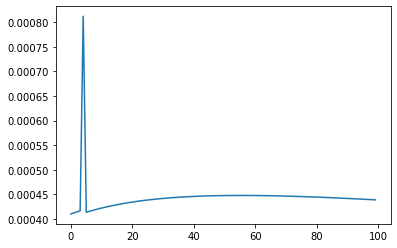

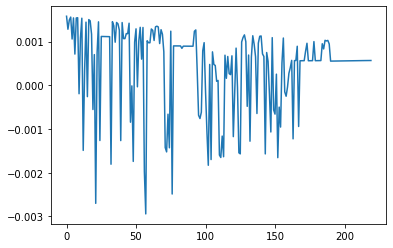

In [20]:
GeneratePlots(X, start_offset, w_size, a, 7, y_bin)

In [22]:
from sklearn.model_selection import train_test_split

N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])

NameError: name 'start_offset' is not defined

In [23]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=60)
dtc_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    dtc.n_estimators = i
    dtc.fit(X_train, y_train.ravel())
    dtc_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))


100% |########################################################################|


In [24]:
data = arff.loadarff('Data_VPN/TimeBasedFeatures-Dataset-30s-VPN.arff')
df = pd.DataFrame(data[0])

X = df.drop('class1', axis=1)
y = df["class1"]

lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
  if y[i] == b'Non-VPN':
    y_bin[i] = 0
  if y[i] == b'VPN':
    y_bin[i] = 1 

scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)


N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])

100% |########################################################################|


In [25]:
RF = RandomForestClassifier()
RF_pr = []
RF_rc = []
RF_f1 = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_pr.append(precision_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
    RF_rc.append(recall_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
    RF_f1.append(f1_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))

print ("Pr",max(RF_pr)   ) 
print ("Rc",max(RF_rc))
print ("F1",max(RF_f1))

Pr 0.9656010239964087
Rc 0.9651169950738916
F1 0.9653457585120377


In [26]:
def open_and_preprocessed (data):

    data = arff.loadarff(data)
    df = pd.DataFrame(data[0])
    
    X = df.drop('class1', axis=1)
    y = df["class1"]

    lb = preprocessing.LabelBinarizer()
    y_bin = np.zeros(len(y))

    for i in range(0, len(y)):
      if y[i] == b'Non-VPN':
        y_bin[i] = 0
      if y[i] == b'VPN':
        y_bin[i] = 1 

    scaler = MinMaxScaler()
    X = np.nan_to_num(X)
    scaler.fit(X)
    X = scaler.transform(X)

    w_size = 500
    a = 1
    start_offset = 0
    X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

    N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
    X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                        test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])
    
    return X_train_full, X_test_full, y_train_full, y_test_full

In [27]:
X_tr15, X_t15, y_tr15, y_t15 = open_and_preprocessed ('Data_VPN/TimeBasedFeatures-Dataset-15s-VPN.arff')

100% |########################################################################|


In [28]:
def model_quality(X_train_full, X_test_full, y_train_full, y_test_full, model):
    RF = model
    RF_pr = []
    RF_rc = []
    RF_f1 = []

    progress = progressbar.ProgressBar()
    for i in progress(range(1, 20)):
        RF.n_estimators = i
        RF.fit(X_train_full, y_train_full.ravel())
        RF_pr.append(precision_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
        RF_rc.append(recall_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
        RF_f1.append(f1_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))

    print ("Pr",max(RF_pr)) 
    print ("Rc",max(RF_rc))
    print ("F1",max(RF_f1))

In [29]:
model_quality(X_tr15, X_t15, y_tr15, y_t15, RandomForestClassifier())

Pr 0.9619775950633465
Rc 0.961712293994206
F1 0.9618396094393762


In [30]:
X_tr30, X_t30, y_tr30, y_t30 = open_and_preprocessed ('Data_VPN/TimeBasedFeatures-Dataset-30s-VPN.arff')

100% |########################################################################|


In [31]:
model_quality(X_tr30, X_t30, y_tr30, y_t30, RandomForestClassifier())

Pr 0.9619088016967126
Rc 0.9624384236453202
F1 0.962153043035396


In [32]:
X_tr60, X_t60, y_tr60, y_t60 = open_and_preprocessed ('Data_VPN/TimeBasedFeatures-Dataset-60s-VPN.arff')

100% |########################################################################|


In [33]:
model_quality(X_tr60, X_t60, y_tr60, y_t60, RandomForestClassifier())

Pr 0.9651978623590178
Rc 0.963888057467824
F1 0.9645040478591931


In [34]:
X_tr120, X_t120, y_tr120, y_t120 = open_and_preprocessed ('Data_VPN/TimeBasedFeatures-Dataset-120s-VPN.arff')

100% |########################################################################|


In [35]:
model_quality(X_tr120, X_t120, y_tr120, y_t120, RandomForestClassifier())

Pr 0.9651199152281484
Rc 0.9653300800079753
F1 0.965222529723418


## Разные классификаторы 

In [35]:
X_tr60, X_t60, y_tr60, y_t60 = open_and_preprocessed ('Data_VPN/TimeBasedFeatures-Dataset-60s-VPN.arff')

100% |########################################################################|


In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [37]:
model_quality(X_tr60, X_t60, y_tr60, y_t60, DecisionTreeClassifier(random_state=60))

Pr 0.9321422540304984
Rc 0.9327157666099462
F1 0.9324190160266681


In [38]:
model_quality(X_tr60, X_t60, y_tr60, y_t60, LogisticRegression(random_state=60))

Pr 0.4557608695652174
Rc 0.4980967395043367
F1 0.3623315203193478


In [41]:
from sklearn.metrics import precision_score, recall_score,f1_score

RF = RandomForestClassifier()
RF_pr = []
RF_rc = []
RF_f1 = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_pr.append(precision_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
    RF_rc.append(recall_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
    RF_f1.append(f1_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))

print ("Pr",max(RF_pr)   ) 
print ("Rc",max(RF_rc))
print ("F1",max(RF_f1))

Pr 0.9596597721577711
Rc 0.958352141292688
F1 0.958903387028319


In [39]:
model_quality(X_tr60, X_t60, y_tr60, y_t60, SVC(kernel='linear', C=1.0, random_state=1))

/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ksant/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classi

Pr 0.27623655913978495
Rc 0.5
F1 0.3558664634990996


In [40]:
model_quality(X_tr60, X_t60, y_tr60, y_t60, SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0))

Pr 0.5463748797813286
Rc 0.5035987990473035
F1 0.3770772488544128


In [42]:
model_quality(X_tr60, X_t60, y_tr60, y_t60, KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski'))

Pr 0.912808825372102
Rc 0.9122661444656084
F1 0.9125289370915866


In [52]:
def model_quality(X_train_full, X_test_full, y_train_full, y_test_full, model):
    RF = model
    RF_pr = []
    RF_rc = []
    RF_f1 = []

    progress = progressbar.ProgressBar()
    for i in progress(range(1, 20)):
        RF.n_estimators = i
        RF.fit(X_train_full, y_train_full.ravel())
        RF_pr.append(precision_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
        RF_rc.append(recall_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))
        RF_f1.append(f1_score(y_test_full.ravel(), RF.predict(X_test_full), average="macro"))

    print ("Pr",max(RF_pr)   ) 
    print ("Rc",max(RF_rc))
    print ("F1",max(RF_f1))

In [89]:
import pandas as pd
import phik
from phik import resources, report

# open fake car insurance data
data = arff.loadarff('Data_VPN/TimeBasedFeatures-Dataset-60s-VPN.arff')
df = pd.DataFrame(data[0])

# Pearson's correlation matrix between numeric variables (pandas functionality)
df.corr()

# get the phi_k correlation matrix between all variables
df.phik_matrix()

# get global correlations based on phi_k correlation matrix
df.global_phik()

# get the significance matrix (expressed as one-sided Z)
# of the hypothesis test of each variable-pair dependency
df.significance_matrix()

interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']
interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']


/home/ksant/.local/lib/python3.7/site-packages/phik/phik.py:248: RuntimeWarning: invalid value encountered in sqrt
  global_correlations = np.array([[np.sqrt(1 - 1/(V[i][i] * Vinv[i][i]))] for i in range(V.shape[0])])


interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']


,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
duration,67.093933,13.785240,10.803897,50.544729,23.573875,34.412246,14.848826,43.141754,18.056925,-0.562286,...,48.923531,54.584555,55.917424,57.969544,12.889121,54.023346,55.176428,57.476111,13.144919,10.543623
total_fiat,13.785240,136.917364,100.488546,2.783101,1.611485,92.806747,94.552287,5.092334,24.910775,0.024109,...,47.770844,3.309339,3.639820,3.942210,13.970462,3.280686,3.494944,3.861880,14.105702,25.679613
total_biat,10.803897,100.488546,124.852471,2.144357,1.235443,64.451577,110.929724,12.510822,13.930316,-0.131415,...,52.812608,2.628069,2.967775,3.209281,6.633718,2.576541,2.825561,3.131016,6.474954,24.006156
min_fiat,50.544729,2.783101,2.144357,54.949029,-0.944622,33.605018,2.181827,46.361447,0.294403,-0.712627,...,41.978094,48.016772,49.624864,52.199100,11.658571,48.211504,49.574555,52.396568,11.771734,14.559805
min_biat,23.573875,1.611485,1.235443,-0.944622,37.884130,2.019374,16.939707,-0.355696,27.750756,-0.308701,...,17.616180,22.648556,22.788308,23.737436,8.140606,22.340543,22.530704,23.425192,8.323010,7.284887
max_fiat,34.412246,92.806747,64.451577,33.605018,2.019374,113.400860,71.846543,41.091045,24.023422,0.524000,...,63.562194,32.733657,32.844147,32.732906,11.391026,32.826108,32.902100,32.782087,11.806586,23.653514
max_biat,14.848826,94.552287,110.929724,2.181827,16.939707,71.846543,149.616725,24.777457,58.369627,0.593694,...,59.654845,10.708972,10.193785,10.105944,22.871238,10.891437,10.335031,10.151041,23.769542,27.767151
mean_fiat,43.141754,5.092334,12.510822,46.361447,-0.355696,41.091045,24.777457,67.440485,24.449038,-0.553303,...,54.840206,42.726053,43.714054,44.308816,8.685922,42.836342,43.790045,44.405440,8.830814,10.786994
mean_biat,18.056925,24.910775,13.930316,0.294403,27.750756,24.023422,58.369627,24.449038,113.619671,0.473107,...,33.080639,19.134378,18.944070,18.912364,35.902694,19.483800,19.017030,18.929107,36.973638,10.161446
flowPktsPerSecond,-0.562286,0.024109,-0.131415,-0.712627,-0.308701,0.524000,0.593694,-0.553303,0.473107,24.073062,...,0.337526,-0.810159,-0.690491,-0.667866,-0.009210,-0.831024,-0.749920,-0.698751,-0.101921,1.734455


interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']
interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']


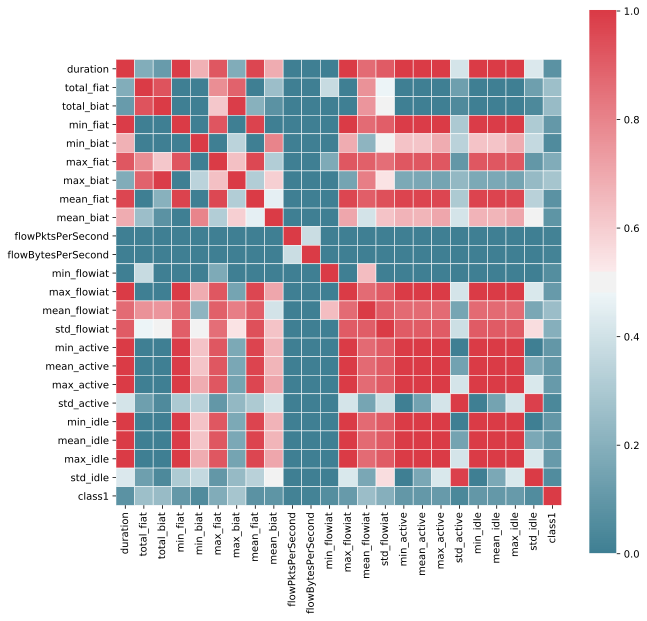

In [90]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.phik_matrix(), mask=np.zeros_like(df.phik_matrix(), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, linewidths=.5)

In [91]:
global_correlation, global_labels = df.global_phik()
for c, l in zip(global_correlation, global_labels):
    print(l, c[0])

interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']
duration 0.9983434086182311
total_fiat 0.09535639520588743
total_biat 0.8071701695812192
min_fiat nan
min_biat nan
max_fiat 0.9567633128156798
max_biat 1.3360760730475851
mean_fiat 0.9012866813976647
mean_biat nan
flowPktsPerSecond 0.380770770786498
flowBytesPerSecond 0.38087549887539657
min_flowiat nan
max_flowiat 1.0
mean_flowiat 0.9165697988554041
std_flowiat 0.9902382912710678
min_active 1.0000640697545156
mean_active 1.000056495895636
max_active 0.9995420095852783
std_active 1.2628321637208175
min_idle 1.0000618975481586
mean_idle 1.0000720571857642
max_idle 1.0
std_idle 1.3310518596566037
class1 0.7479938568119513


/home/ksant/.local/lib/python3.7/site-packages/phik/phik.py:248: RuntimeWarning: invalid value encountered in sqrt
  global_correlations = np.array([[np.sqrt(1 - 1/(V[i][i] * Vinv[i][i]))] for i in range(V.shape[0])])


In [92]:
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

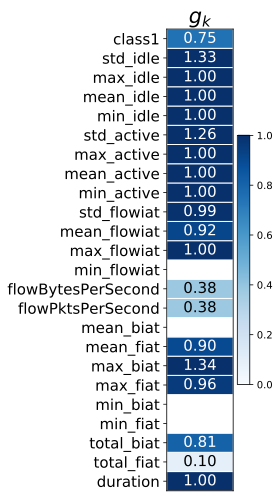

In [93]:
plot_correlation_matrix(global_correlation, x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(4,7),
                        color_map='Blues', title=r'$g_k$',
                        fontsize_factor=1.5)
plt.tight_layout()

In [94]:
df.phik_matrix()

interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']


,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
duration,1.000000,0.185614,0.113856,0.993256,0.676473,0.920075,0.180673,0.966102,0.689810,0.000000,...,0.909105,0.998111,0.997938,0.999170,0.407430,0.997915,0.997746,0.999054,0.427412,0.080497
total_fiat,0.185614,1.000000,0.931368,0.000000,0.000000,0.773145,0.890169,0.000000,0.257350,0.000000,...,0.473723,0.000000,0.000000,0.000000,0.131518,0.000000,0.000000,0.000000,0.132001,0.257831
total_biat,0.113856,0.931368,1.000000,0.000000,0.000000,0.614586,0.991664,0.199232,0.080901,0.000000,...,0.510457,0.000000,0.000000,0.000000,0.045974,0.000000,0.000000,0.000000,0.042135,0.242330
min_fiat,0.993256,0.000000,0.000000,1.000000,0.000000,0.925170,0.000000,0.975807,0.000000,0.000000,...,0.899557,0.995330,0.995492,0.996629,0.297709,0.995676,0.995738,0.996926,0.306224,0.104445
min_biat,0.676473,0.000000,0.000000,0.000000,1.000000,0.000000,0.340557,0.000000,0.796956,0.000000,...,0.486117,0.628578,0.622906,0.689037,0.336671,0.627690,0.622706,0.688125,0.366893,0.047071
max_fiat,0.920075,0.773145,0.614586,0.925170,0.000000,1.000000,0.635203,0.957794,0.320095,0.000000,...,0.857947,0.921409,0.921278,0.920218,0.097727,0.921605,0.921443,0.920397,0.100961,0.183028
max_biat,0.180673,0.890169,0.991664,0.000000,0.340557,0.635203,1.000000,0.320193,0.593829,0.000000,...,0.542612,0.168300,0.163152,0.150517,0.232329,0.169991,0.165088,0.151756,0.241004,0.281618
mean_fiat,0.966102,0.000000,0.199232,0.975807,0.000000,0.957794,0.320193,1.000000,0.456758,0.000000,...,0.940072,0.968832,0.969923,0.968064,0.302303,0.969034,0.970134,0.968258,0.333970,0.081398
mean_biat,0.689810,0.257350,0.080901,0.000000,0.796956,0.320095,0.593829,0.456758,1.000000,0.000000,...,0.625919,0.669302,0.664882,0.705123,0.407603,0.671789,0.667518,0.706705,0.511340,0.089076
flowPktsPerSecond,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014848


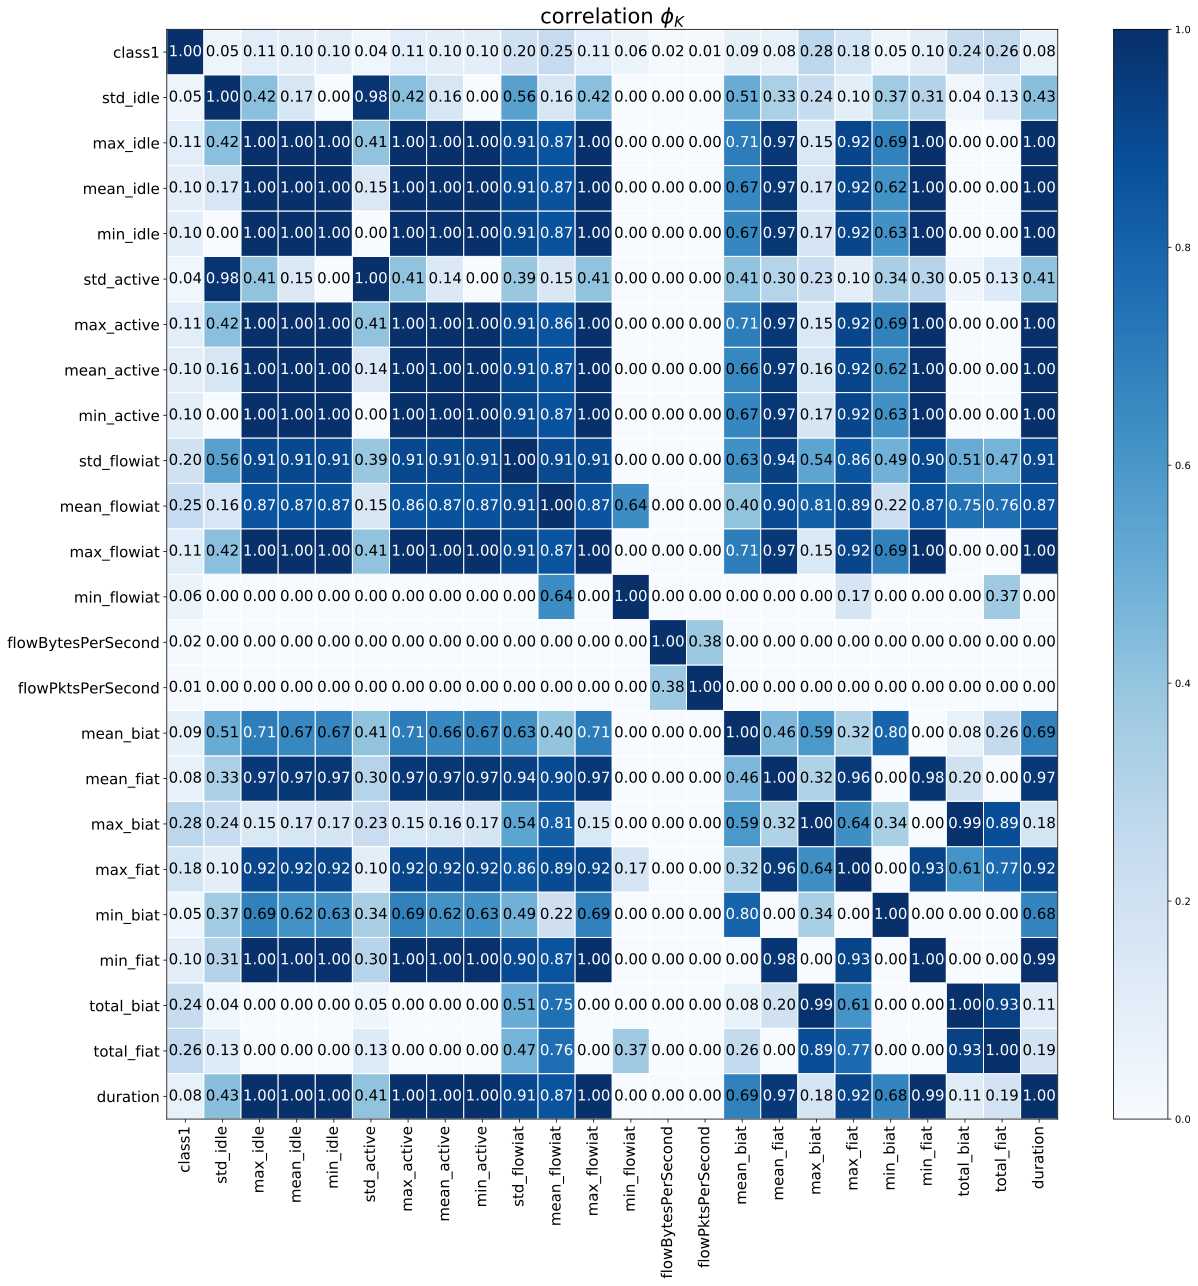

In [96]:
phik_overview = df.phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(18,18))
plt.tight_layout()

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.phik_matrix(), mask=np.zeros_like(df.phik_matrix(), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, linewidths=.5)

In [133]:
small_df = df [["max_biat","total_fiat","total_biat","min_fiat", "class1"]]

In [155]:
phik_overview = small_df.phik_matrix()

interval columns not set, guessing: ['max_biat', 'total_fiat', 'total_biat', 'min_fiat']


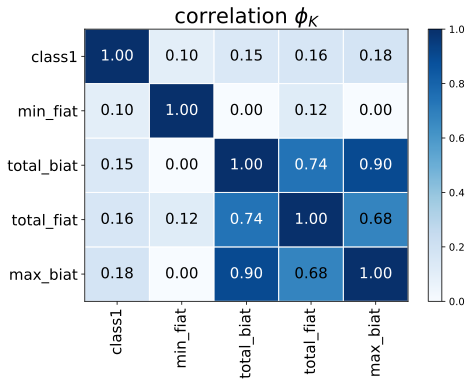

In [156]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(7,5.5))
plt.tight_layout()

In [153]:
significance_overview = small_df.significance_matrix()

interval columns not set, guessing: ['max_biat', 'total_fiat', 'total_biat', 'min_fiat']


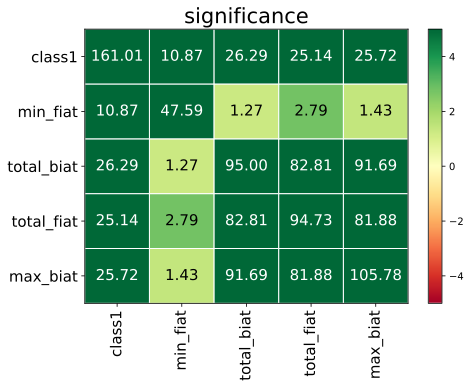

In [154]:
plot_correlation_matrix(significance_overview.fillna(0).values, x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, vmin=-5, vmax=5, title='significance', 
                        usetex=False, fontsize_factor=1.5, figsize=(7,5.5))
plt.tight_layout()

In [134]:
small_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18758 entries, 0 to 18757
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   max_biat    18758 non-null  float64
 1   total_fiat  18758 non-null  float64
 2   total_biat  18758 non-null  float64
 3   min_fiat    18758 non-null  float64
 4   class1      18758 non-null  object 
dtypes: float64(4), object(1)
memory usage: 732.9+ KB


In [135]:
small_df.shape

(18758, 5)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = small_df.drop('class1', axis=1)
y = small_df["class1"]

from sklearn import preprocessing
import numpy as np

lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
  if y[i] == b'Non-VPN':
    y_bin[i] = 0
  if y[i] == b'VPN':
    y_bin[i] = 1  

scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3,random_state = 42, shuffle=True, stratify=y_bin)

NameError: name 'small_df' is not defined

In [ ]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train, y_train.ravel())
    RF_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))



In [ ]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

In [149]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=60)
dtc_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    dtc.n_estimators = i
    dtc.fit(X_train, y_train.ravel())
    dtc_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))

100% |########################################################################|


0.8384861407249466


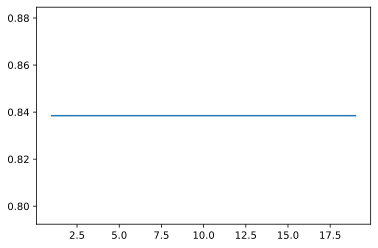

In [151]:
plt.plot(range(1, 20), dtc_acc, label="Accuracy")
print(max(dtc_acc))

In [152]:
text_representation = tree.export_text(dtc)
print(text_representation)

|--- feature_3 <= 0.00
|   |--- feature_3 <= 0.00
|   |   |--- feature_1 <= 0.00
|   |   |   |--- feature_0 <= 0.00
|   |   |   |   |--- feature_0 <= 0.00
|   |   |   |   |   |--- feature_0 <= 0.00
|   |   |   |   |   |   |--- feature_0 <= 0.00
|   |   |   |   |   |   |   |--- feature_1 <= 0.00
|   |   |   |   |   |   |   |   |--- feature_3 <= 0.00
|   |   |   |   |   |   |   |   |   |--- feature_2 <= 0.00
|   |   |   |   |   |   |   |   |   |   |--- feature_1 <= 0.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 14
|   |   |   |   |   |   |   |   |   |   |--- feature_1 >  0.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- feature_2 >  0.00
|   |   |   |   |   |   |   |   |   |   |--- feature_2 <= 0.00
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |   |--- feature_2 >  0.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branc

<bound method BaseDecisionTree.decision_path of DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=60, splitter='best')>


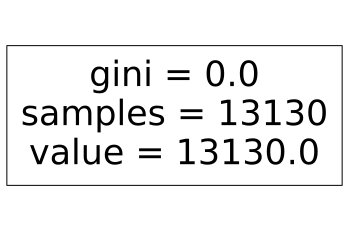

In [142]:
from sklearn import tree
#single_tree = model_reduced.estimators_[105][0]

tree.plot_tree(dtc)

print(dtc.decision_path)

In [81]:
data = arff.loadarff('Data_VPN/TimeBasedFeatures-Dataset-60s-VPN.arff')
df = pd.DataFrame(data[0])

In [82]:
from itertools import combinations_with_replacement, combinations
feature_combs_2 = list(combinations(df.columns, 2))

In [83]:
corr_list=[]
for l in range(len(feature_combs_2)):
    sp = kendalltau (df[feature_combs_2[l][0]],df[feature_combs_2[l][1]])
    corr_list.append ([sp[0], sp[1],feature_combs_2[l]])
    
corr_list.sort(key=lambda x: x[0])
corr_list[-28:-1]

[[0.7690802278227392, 0.0, ('min_fiat', 'std_flowiat')],
 [0.7761736359320018, 0.0, ('min_fiat', 'max_idle')],
 [0.7861278038336029, 0.0, ('std_flowiat', 'mean_idle')],
 [0.7876988620902511, 0.0, ('min_fiat', 'max_fiat')],
 [0.7881048996625362, 0.0, ('max_flowiat', 'std_flowiat')],
 [0.8039723317425864, 0.0, ('max_flowiat', 'mean_active')],
 [0.8073829437832974, 0.0, ('min_biat', 'max_biat')],
 [0.810847344425565, 0.0, ('min_fiat', 'max_flowiat')],
 [0.8201737053915075, 0.0, ('max_flowiat', 'mean_idle')],
 [0.8326691554746279, 0.0, ('max_flowiat', 'max_active')],
 [0.841955238114581, 0.0, ('max_active', 'min_idle')],
 [0.8556252033122219, 0.0, ('min_active', 'max_idle')],
 [0.8585633594358677, 0.0, ('flowPktsPerSecond', 'flowBytesPerSecond')],
 [0.8601207409216909, 0.0, ('min_active', 'max_active')],
 [0.8673656451834595, 0.0, ('min_idle', 'max_idle')],
 [0.8713201530816265, 0.0, ('max_flowiat', 'max_idle')],
 [0.8998756679342539, 0.0, ('mean_active', 'min_idle')],
 [0.9066567893324468

In [84]:
df_no_corrs = df.drop(['mean_active',"min_active", "max_active","min_idle"], axis = 1)

In [85]:
feature_combs_2 = list(combinations(df_no_corrs.columns, 2))

corr_list=[]
for l in range(len(feature_combs_2)):
    sp = kendalltau (df_no_corrs[feature_combs_2[l][0]],df_no_corrs[feature_combs_2[l][1]])
    corr_list.append ([sp[0], sp[1],feature_combs_2[l]])
    
corr_list.sort(key=lambda x: x[0])
corr_list[-28:-1]

[[0.664064866531191, 0.0, ('min_biat', 'mean_biat')],
 [0.6653810396096046, 0.0, ('max_biat', 'mean_flowiat')],
 [0.6861740182880454, 0.0, ('max_fiat', 'max_biat')],
 [0.6924473109036997, 0.0, ('min_biat', 'mean_idle')],
 [0.7169715511007237, 0.0, ('max_flowiat', 'mean_flowiat')],
 [0.7180290726110825, 0.0, ('mean_fiat', 'mean_biat')],
 [0.7195815685127467, 0.0, ('mean_flowiat', 'std_flowiat')],
 [0.728240631411474, 0.0, ('max_fiat', 'mean_flowiat')],
 [0.734673609942794, 0.0, ('min_biat', 'max_idle')],
 [0.7352214865639107, 0.0, ('min_fiat', 'mean_idle')],
 [0.7386840680577689, 0.0, ('min_fiat', 'min_biat')],
 [0.7408472626051525, 0.0, ('min_biat', 'std_flowiat')],
 [0.7514689956634092, 0.0, ('max_biat', 'std_flowiat')],
 [0.7542491317607541, 0.0, ('max_fiat', 'std_flowiat')],
 [0.7632943276961235, 0.0, ('min_biat', 'max_flowiat')],
 [0.7640422678740519, 0.0, ('std_flowiat', 'max_idle')],
 [0.7690802278227392, 0.0, ('min_fiat', 'std_flowiat')],
 [0.7761736359320018, 0.0, ('min_fiat', 

In [86]:
df_no_corrs = df_no_corrs.drop(["mean_idle",'max_flowiat'], axis = 1)

In [87]:
X = df_no_corrs.drop('class1', axis=1)
y = df_no_corrs["class1"]

lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
    if y[i] == b'Non-VPN':
        y_bin[i] = 0
    if y[i] == b'VPN':
        y_bin[i] = 1 

scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                        test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])


100% |########################################################################|


In [88]:
model_quality(X_train_full, X_test_full, y_train_full, y_test_full, RandomForestClassifier())

Pr 0.9760374265038444
Rc 0.9725033571270512
F1 0.974033340843103


In [99]:
df_no_corrs = df_no_corrs.drop(["min_fiat",'max_'], axis = 1)

In [100]:
X = df_no_corrs.drop('class1', axis=1)
y = df_no_corrs["class1"]

lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
    if y[i] == b'Non-VPN':
        y_bin[i] = 0
    if y[i] == b'VPN':
        y_bin[i] = 1 

scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                        test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])


100% |########################################################################|


In [101]:
model_quality(X_train_full, X_test_full, y_train_full, y_test_full, RandomForestClassifier())

Pr 0.9719503066126609
Rc 0.9702287862915295
F1 0.9710256905543752


interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'mean_flowiat', 'std_flowiat', 'std_active', 'std_idle']
interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'mean_flowiat', 'std_flowiat', 'std_active', 'std_idle']


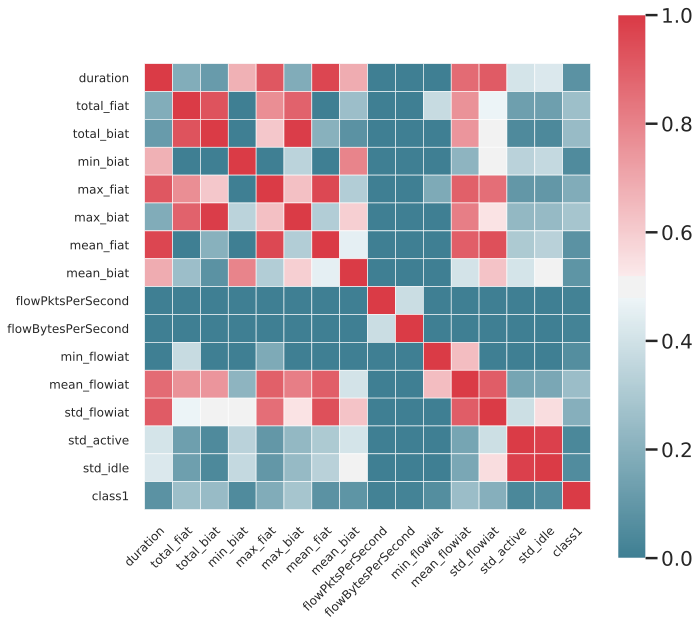

In [135]:
f, ax = plt.subplots(figsize=(10, 10))

#sns.set(font_scale=1.5) - все одновременно
im = sns.heatmap(df_no_corrs.phik_matrix(), mask=np.zeros_like(df_no_corrs.phik_matrix(), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, linewidths=.6)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12, rotation_mode='anchor', ha='right')

#sns.set_context("poster",font_scale=1.0)

# use matplotlib.colorbar.Colorbar object
cbar = im.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)
plt.show()


f.savefig("Hurst/heat_2.jpeg", dpi=400, transparent=True, bbox_inches='tight')

interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'mean_flowiat', 'std_flowiat', 'std_active', 'std_idle']


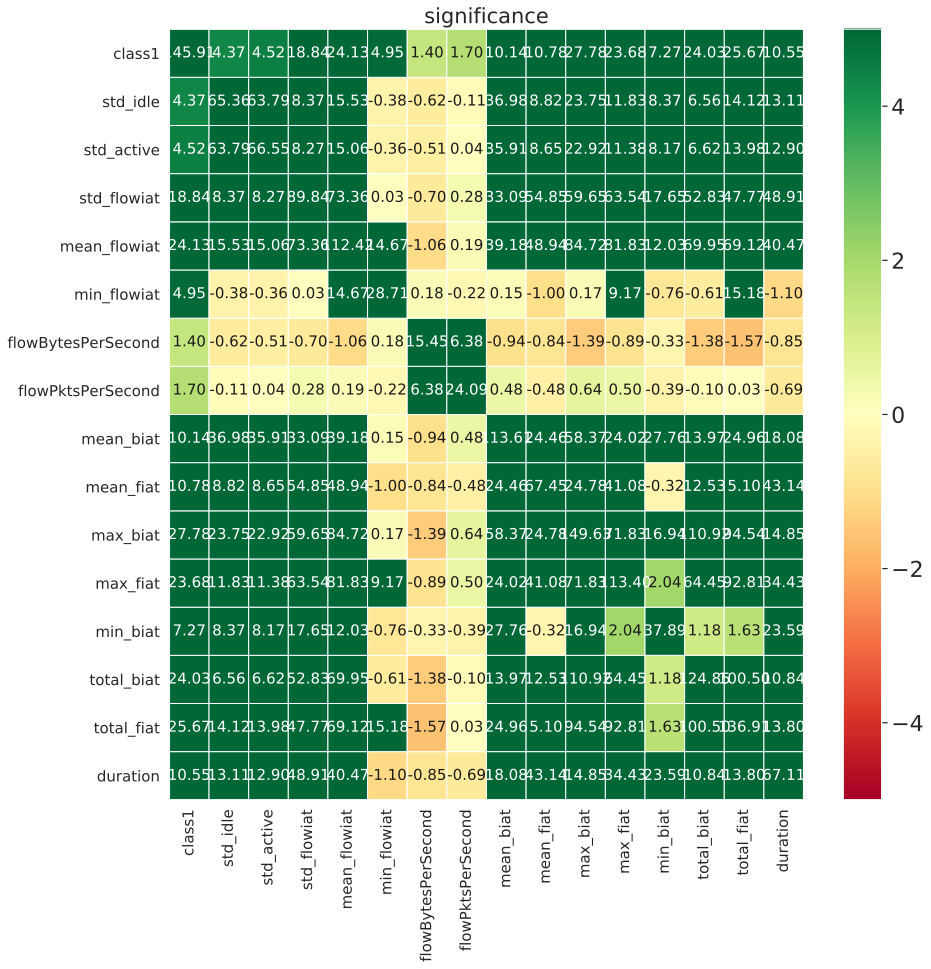

In [126]:
significance_overview = df_no_corrs.significance_matrix()
plot_correlation_matrix(significance_overview.fillna(0).values, x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, vmin=-5, vmax=5, title='significance', 
                        usetex=False, fontsize_factor=1.5, figsize=(14,14))
plt.tight_layout()

In [ ]:

plt.savefig("Hurst/sign.jpeg", dpi=400, transparent=True, bbox_inches='tight')

interval columns not set, guessing: ['duration', 'total_fiat', 'total_biat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'mean_flowiat', 'std_flowiat', 'std_active', 'std_idle']


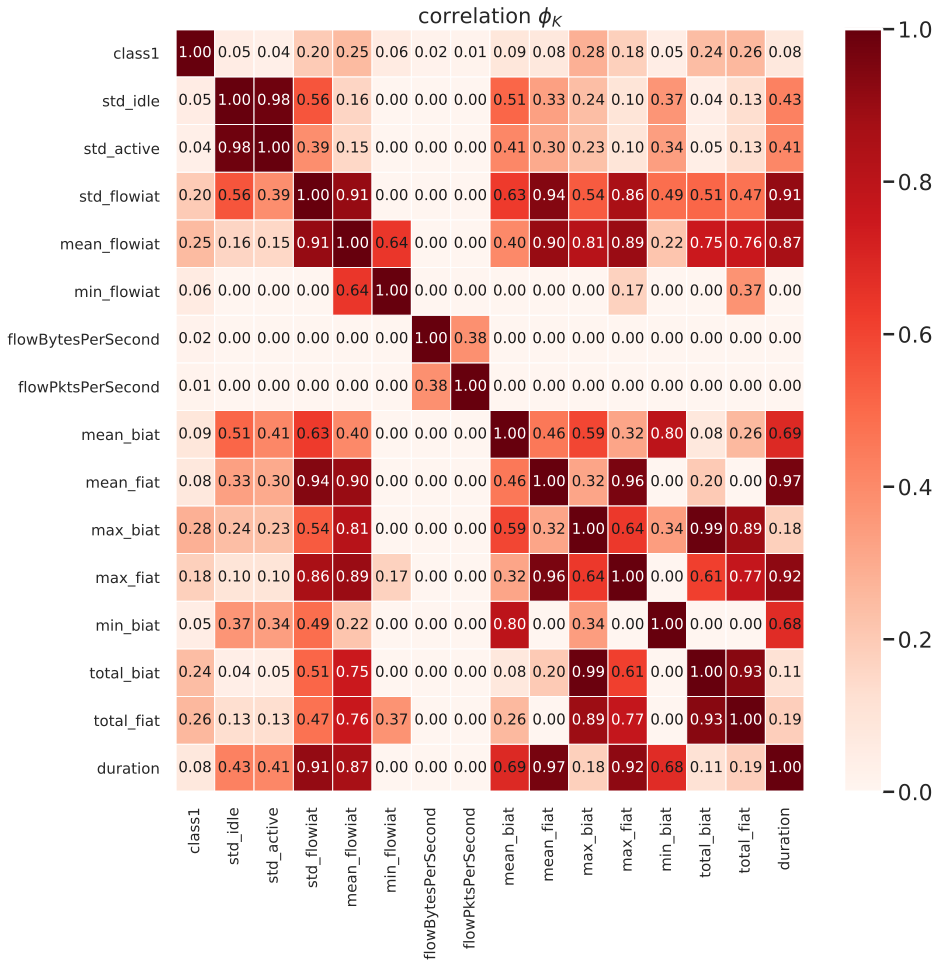

In [141]:
phik_overview = df_no_corrs.phik_matrix()
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Reds', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(14,14), print_both_numbers = False)
plt.tight_layout()
plt.savefig("Hurst/assss.jpeg", dpi=400, transparent=True, bbox_inches='tight')



# 30 s

In [36]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('Data_VPN/TimeBasedFeatures-Dataset-30s-VPN.arff')
df = pd.DataFrame(data[0])

In [37]:
X = df.drop('class1', axis=1)
y = df["class1"]

In [38]:
from sklearn import preprocessing
import numpy as np

lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
  if y[i] == b'Non-VPN':
    y_bin[i] = 0
  if y[i] == b'VPN':
    y_bin[i] = 1  

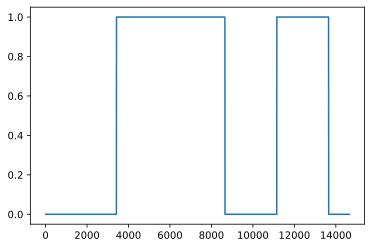

In [39]:
plt.plot(y_bin)

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3,random_state = 42, shuffle=True, stratify=y_bin)

## Random Forest

In [41]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train, y_train.ravel())
    RF_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))

100% |########################################################################|


0.8760236578707916


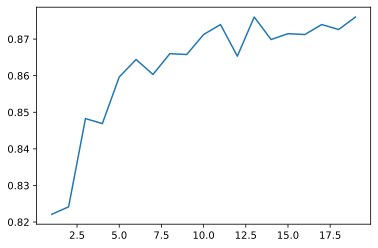

In [42]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

## Hurst

In [43]:
w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

100% |########################################################################|


In [44]:
N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])

In [45]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_acc.append(accuracy_score(y_test_full.ravel(), RF.predict(X_test_full)))

100% |########################################################################|


0.9659770114942529


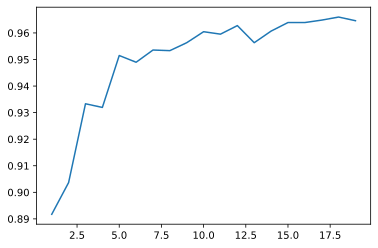

In [46]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

# 60 s

In [47]:
data = arff.loadarff('Data_VPN/TimeBasedFeatures-Dataset-60s-VPN.arff')
df = pd.DataFrame(data[0])

In [48]:
X = df.drop('class1', axis=1)
y = df["class1"]

In [49]:
lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
  if y[i] == b'Non-VPN':
    y_bin[i] = 0
  if y[i] == b'VPN':
    y_bin[i] = 1  

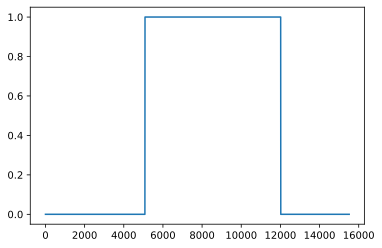

In [50]:
plt.plot(y_bin)

In [51]:
scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3,random_state = 42, shuffle=True, stratify=y_bin)

In [52]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train, y_train.ravel())
    RF_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))

100% |########################################################################|


0.869172932330827


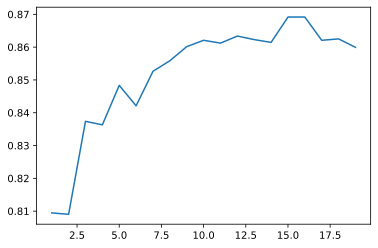

In [53]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

In [54]:
model_quality(X_train, X_test, y_train, y_test, KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski'))

Pr 0.8050081873758336
Rc 0.8013525264846746
F1 0.802737807102859


## Hurst

In [34]:
w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

100% |########################################################################|


In [35]:
N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])

In [36]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_acc.append(accuracy_score(y_test_full.ravel(), RF.predict(X_test_full)))

100% |########################################################################|


0.967027027027027


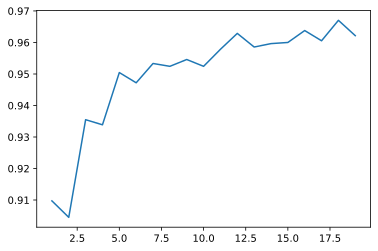

In [37]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

# 120 s

In [35]:
data = arff.loadarff('Data_VPN/TimeBasedFeatures-Dataset-120s-VPN.arff')
df = pd.DataFrame(data[0])

In [36]:
X = df.drop('class1', axis=1)
y = df["class1"]

In [37]:
lb = preprocessing.LabelBinarizer()
y_bin = np.zeros(len(y))

for i in range(0, len(y)):
  if y[i] == b'Non-VPN':
    y_bin[i] = 0
  if y[i] == b'VPN':
    y_bin[i] = 1  

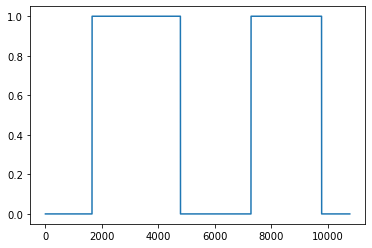

In [38]:
plt.plot(y_bin)

In [39]:
scaler = MinMaxScaler()
X = np.nan_to_num(X)
scaler.fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.3,random_state = 42, shuffle=True, stratify=y_bin)

In [40]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train, y_train.ravel())
    RF_acc.append(accuracy_score(y_test.ravel(), RF.predict(X_test)))

100% |########################################################################|


0.8769706336939722


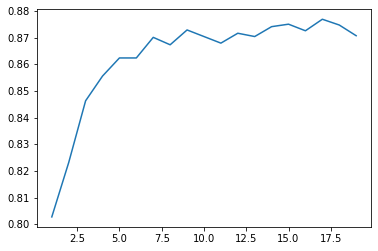

In [41]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

## Hurst

In [42]:
w_size = 500
a = 1
start_offset = 0
X_new_full = GenerateNewFeatures(X, start_offset, w_size, a)

100% |########################################################################|


In [43]:
N_steps = int(np.floor((X.shape[0] - start_offset) / w_size))
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_new_full, y_bin[0:N_steps*w_size], 
                                                    test_size = 0.3, shuffle=True, stratify=y_bin[0:N_steps*w_size])

In [44]:
RF = RandomForestClassifier()
RF_acc = []

progress = progressbar.ProgressBar()
for i in progress(range(1, 20)):
    RF.n_estimators = i
    RF.fit(X_train_full, y_train_full.ravel())
    RF_acc.append(accuracy_score(y_test_full.ravel(), RF.predict(X_test_full)))

100% |########################################################################|


0.9638095238095238


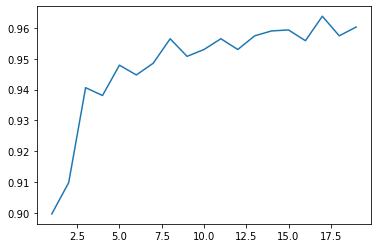

In [45]:
plt.plot(range(1, 20), RF_acc, label="Accuracy")
print(max(RF_acc))

# Сравнение

In [32]:
x = ["15", "30", "60", "120"]
y_RF = [ 0.895344, 0.8753412, 0.8946, 0.87697]
y_RF_SSR = [ 0.963243243, 0.962988505, 0.967027, 0.963]

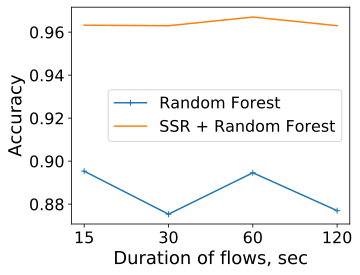

In [33]:
from matplotlib.ticker import FuncFormatter, MaxNLocator
f, ax = plt.subplots(figsize=(5, 4))


ax.plot(x, y_RF, '+', linestyle='solid', label='Random Forest')
ax.plot(x, y_RF_SSR, '--', linestyle='solid', label='SSR + Random Forest')

plt.xlabel('Duration of flows, sec', size = 18);
plt.ylabel('Accuracy', size = 18);
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

ax.legend(prop={'size': 16})
f.savefig("Hurst/Accuracy.png", bbox_inches = "tight")

plt.show()